In [38]:
import os
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import layers, Model
from tensorflow.keras.utils import to_categorical
from utils import manage_outlier
def seed_everything(seed:int=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

warnings.filterwarnings('ignore')
seed_everything()

### load data & preprocessing

In [2]:
df = pd.read_csv('./dataset/ff.csv')

def make_targets(targets):
    return 1 if targets >=5 else 0

df['BE5_1'] = df.apply(
    lambda row: make_targets(row['BE5_1']), axis=1
)
drops = df.isna().sum().sort_values(ascending=False) / df.shape[0] * 100
df = df[drops[drops.values <= 10].index]
# feature importance 기반 변수 제거(1차)
df.drop(['LQ_1EQL', 'LQ_2EQL', 'LQ_3EQL', 'LQ_4EQL', 'LQ_5EQL'], axis=1, inplace=True)
# corr matrix 기반 변수 제거(2차)
df.drop(['EC1_1'], axis=1, inplace=True)
# feature importance 기반 변수 제거(3차)
df.drop(['cage', 'LQ1_sb', 'LQ1_mn', 'LQ4_00'], axis=1, inplace=True)
# feture importance 기반 변수 제거(4차)
df.drop(['BD1', 'mh_stress', 'BS3_1'], axis=1, inplace=True)
# feture importance 기반 변수 제거(5차)
df.drop(['BO1_1', 'BO2_1'], axis=1, inplace=True)

In [3]:
# 1차년도
NUMERIC = ['HE_FEV1FVC', 'age', 'Total_slp_wk']
CATEGORICAL = ['sex', 'occp', 'EC1_1', 'cfam', 'marri_1', 'BH9_11', 'HE_DM', 'DC6_dg', 'DF2_dg', 'HE_HPdg', 'BP5']
ONE_HOT = ['BS3_1', 'edu', 'BP1', 'D_1_1', 'LQ_1EQL', 'LQ_2EQL', 'LQ_3EQL', 'LQ_4EQL', 'LQ_5EQL', 'BO1_1', 'BO2_1']
# 2차년도
NUMERIC2 = ['DI1_ag', 'DE1_ag', 'LQ1_mn', 'BS6_2_1', 'BS6_3']
CATEGORICAL2 = ['DI1_pt', 'DE1_pt', 'DE1_3', 'BH1', 'BH2_61', 'LQ4_00', 'LQ4_05', 'LQ1_sb', 'MO1_wk', 'HE_cough1', 'HE_sput1', 'BD1', 'BD7_5', 'BP6_10', 'BP6_31']
ONE_HOT2 = ['DI1_2', 'EC_pedu_1', 'EC_pedu_2', 'BS5_1', 'BD7_4']
# 생성변수
NUMERIC3 = ['eq_5d']
CATEGORICAL3 = ['sm_present', 'mh_stress']
ONE_HOT3 = ['cage']
# Targets
TARGETS = ['BE3_31', 'BE5_1']

f_NUMERIC = (NUMERIC + NUMERIC2 + NUMERIC3).copy()
f_CATEGORICAL = (CATEGORICAL + CATEGORICAL2 + CATEGORICAL3).copy()
f_ONE_HOT = (ONE_HOT + ONE_HOT2 + ONE_HOT3).copy()
f_CATEGORICAL.append('BE3_31')

In [9]:
for value in f_NUMERIC:
    if value not in df.columns:
        print(value)
        f_NUMERIC.remove(value)

for value in f_CATEGORICAL:
    if value not in df.columns:
        print(value)
        f_CATEGORICAL.remove(value)

for value in f_ONE_HOT:
    if value not in df.columns:
        print(value)
        f_ONE_HOT.remove(value)

In [10]:
# 결측치 처리
for col in f_NUMERIC:
    df[col].fillna(0, inplace=True)
for col in f_CATEGORICAL:
    df[col].fillna(0, inplace=True)
for col in f_ONE_HOT:
    df[col].fillna(df[col].mode()[0], inplace=True)

In [11]:
# 이상치 제거
for col in f_NUMERIC:
    print(col)
    manage_outlier(df, col)

HE_FEV1FVC
245개 삭제
age
0개 삭제
Total_slp_wk
28개 삭제
BS6_2_1
49개 삭제
BS6_3
220개 삭제
eq_5d
141개 삭제


In [12]:
X = df.drop('BE5_1', axis=1)
y = df['BE5_1']

X_numeric = X[f_NUMERIC]
X_categorical = X[f_CATEGORICAL]
X_onehot = X[f_ONE_HOT]
X_onehot = pd.get_dummies(X_onehot, dtype=float)

X = pd.concat([X_numeric, X_categorical], axis=1)
X = pd.concat([X, X_onehot], axis=1)
# split
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=.2, stratify=y, random_state=42)
scaler = StandardScaler()
train_X[f_NUMERIC] = scaler.fit_transform(train_X[f_NUMERIC])

test_X[f_NUMERIC] = scaler.transform(test_X[f_NUMERIC])

In [13]:
counts = np.bincount(train_y)
print(
    "Number of positive samples in training data: {} ({:.2f}% of total)".format(
        counts[1], 100 * float(counts[1]) / len(train_y)
    )
)

weight_for_0 = 1.0 / counts[0]
weight_for_1 = 1.0 / counts[1]

Number of positive samples in training data: 272 (11.00% of total)


In [41]:
smote = SMOTE(random_state=42)
sm_X, sm_y = smote.fit_resample(train_X, train_y)

In [42]:
print(f'train shape: {train_X.shape, train_y.shape}')
print(f'train(over) shape: {sm_X.shape, sm_y.shape}')
print(f'test shape: {test_X.shape, test_y.shape}')

train shape: ((2473, 33), (2473,))
train(over) shape: ((4402, 33), (4402,))
test shape: ((619, 33), (619,))


### ResNN

In [15]:
class ResidualBlock(layers.Layer):
    def __init__(self, input_dim, hidden_dim):
        super(ResidualBlock, self).__init__()
        self.fc1 = layers.Dense(hidden_dim, input_dim=input_dim)
        self.relu = layers.ReLU()
        self.fc2 = layers.Dense(input_dim, input_dim=hidden_dim)

    def call(self, x):
        residual = x
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x += residual
        return self.relu(x)

In [16]:
class ClassificationModel1(Model):
    def __init__(self, input_dim, hidden_dim, num_classes):
        super(ClassificationModel1, self).__init__()
        self.fc = keras.Sequential([
            layers.Dense(hidden_dim, input_shape=(input_dim,)),
            layers.ReLU(),
            layers.BatchNormalization(),
            layers.Dense(hidden_dim),
            layers.ReLU(),
            layers.Dense(hidden_dim),
            layers.Dropout(.5),
            layers.ReLU(),
            layers.Dense(num_classes, activation='softmax')
        ])

    def call(self, x):
        return self.fc(x)

In [17]:
class ClassificationModel2(Model):
    def __init__(self, input_dim, hidden_dim, num_classes):
        super(ClassificationModel2, self).__init__()
        self.residual = ResidualBlock(input_dim, hidden_dim)
        self.classification = ClassificationModel1(input_dim, hidden_dim, num_classes)

    def call(self, x):
        x = self.residual(x)
        return self.classification(x)

In [18]:
class FocalLoss(keras.losses.Loss):
    def __init__(self, gamma=2.0, alpha=0.25):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha

    def call(self, y_true, y_pred):
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)

        cross_entropy = -y_true * tf.math.log(y_pred)
        weight = self.alpha * y_true * tf.pow((1 - y_pred), self.gamma)
        loss = weight * cross_entropy
        return tf.reduce_sum(loss, axis=-1)

In [53]:
model = ClassificationModel2(33, 512, 2)

# 모델 컴파일
model.compile(optimizer=keras.optimizers.AdamW(learning_rate=0.0001),
              loss=FocalLoss(gamma=2.0, alpha=0.25),
              metrics=['accuracy', tfa.metrics.F1Score(2, average='macro', name='f1')])

callback = keras.callbacks.ModelCheckpoint('./resnn.h5', mode='max', monitor='val_f1', save_best_only=True, save_weights_only=True)
class_weight = {0: weight_for_0, 1: weight_for_1}

# 모델 훈련
history = model.fit(
    sm_X, to_categorical(sm_y), 
    epochs=60, batch_size=32, 
    validation_data=(test_X, to_categorical(test_y)),
    # class_weight=class_weight, 
    callbacks=[callback]
)

Epoch 1/60
138/138 [==============================] - 4s 16ms/step - loss: 0.0559 - accuracy: 0.6547 - f1: 0.6547 - val_loss: 0.0377 - val_accuracy: 0.6769 - val_f1: 0.5475
Epoch 2/60
138/138 [==============================] - 2s 13ms/step - loss: 0.0328 - accuracy: 0.7724 - f1: 0.7724 - val_loss: 0.0364 - val_accuracy: 0.6947 - val_f1: 0.5559
Epoch 3/60
138/138 [==============================] - 2s 13ms/step - loss: 0.0264 - accuracy: 0.8210 - f1: 0.8209 - val_loss: 0.0280 - val_accuracy: 0.8029 - val_f1: 0.5756
Epoch 4/60
138/138 [==============================] - 2s 13ms/step - loss: 0.0212 - accuracy: 0.8639 - f1: 0.8639 - val_loss: 0.0296 - val_accuracy: 0.8110 - val_f1: 0.6069
Epoch 5/60
138/138 [==============================] - 2s 13ms/step - loss: 0.0181 - accuracy: 0.8882 - f1: 0.8882 - val_loss: 0.0348 - val_accuracy: 0.7948 - val_f1: 0.6167
Epoch 6/60
138/138 [==============================] - 2s 14ms/step - loss: 0.0161 - accuracy: 0.9041 - f1: 0.9041 - val_loss: 0.0428 - 

In [55]:
model.load_weights('resnn.h5')

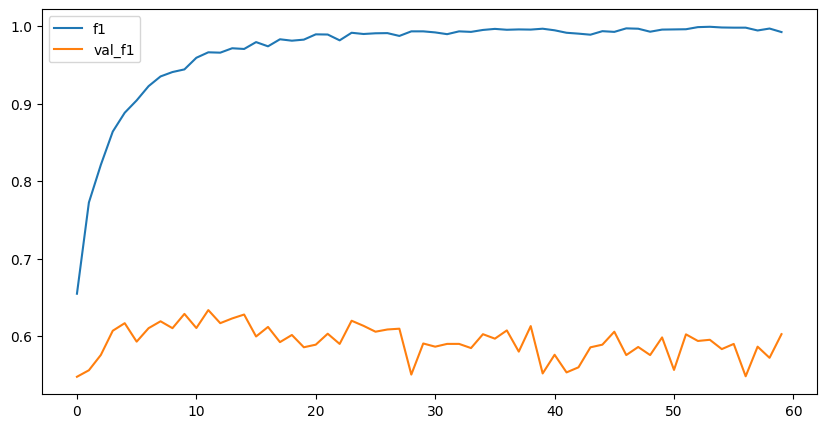

In [54]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['f1'])
plt.plot(history.history['val_f1'])
plt.legend(['f1', 'val_f1'])

In [56]:
preds = tf.argmax(model.predict(test_X), axis=1)

20/20 [==============================] - 0s 4ms/step


In [57]:
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.92      0.92      0.92       551
           1       0.35      0.34      0.35        68

    accuracy                           0.86       619
   macro avg       0.64      0.63      0.63       619
weighted avg       0.86      0.86      0.86       619



<Axes: >

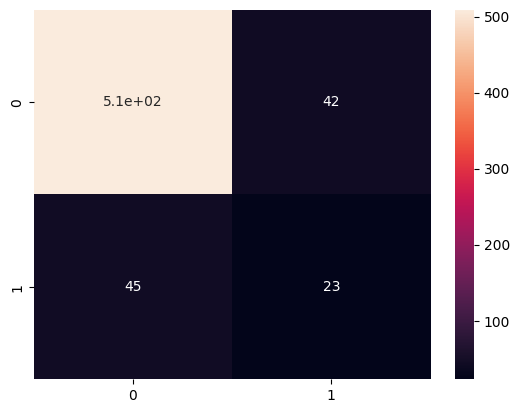

In [58]:
sns.heatmap(confusion_matrix(test_y, preds), annot=True)

In [109]:
model = keras.Sequential(
    [
        keras.Input(shape=train_X.shape[1:]),
        keras.layers.Dense(128, activation="relu"),
        keras.layers.Dense(128, activation="relu"),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(128, activation="relu"),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(2, activation="softmax"),
    ]
)
model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_72 (Dense)            (None, 128)               4352      
                                                                 
 dense_73 (Dense)            (None, 128)               16512     
                                                                 
 dropout_20 (Dropout)        (None, 128)               0         
                                                                 
 dense_74 (Dense)            (None, 128)               16512     
                                                                 
 dropout_21 (Dropout)        (None, 128)               0         
                                                                 
 dense_75 (Dense)            (None, 2)                 258       
                                                                 
Total params: 37634 (147.01 KB)
Trainable params: 376

In [129]:
metrics = [
    # keras.metrics.FalseNegatives(name="fn"),
    # keras.metrics.FalsePositives(name="fp"),
    # keras.metrics.TrueNegatives(name="tn"),
    # keras.metrics.TruePositives(name="tp"),
    # keras.metrics.Precision(name="precision"),
    # keras.metrics.Recall(name="recall"),
    keras.metrics.CategoricalAccuracy(name='acc'),
    tfa.metrics.F1Score(num_classes=2, average='macro', name='f1'),
    keras.metrics.AUC(name='auc'),
]

loss = keras.losses.CategoricalCrossentropy()
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3), loss=loss, metrics=metrics
)

callback = keras.callbacks.ModelCheckpoint('./auto.h5', mode='max', monitor='val_f1', save_best_only=True)
class_weight = {0: weight_for_0, 1: weight_for_1}

hist = model.fit(
    train_X,
    to_categorical(train_y),
    batch_size=128,
    epochs=200,
    verbose=2,
    callbacks=[callback],
    validation_data=(test_X, to_categorical(test_y)),
    class_weight=class_weight,
)

Epoch 1/200
20/20 - 1s - loss: 4.1435e-04 - acc: 0.7392 - f1: 0.6136 - auc: 0.8154 - val_loss: 0.5451 - val_acc: 0.7286 - val_f1: 0.5790 - val_auc: 0.7983 - 1s/epoch - 64ms/step
Epoch 2/200
20/20 - 0s - loss: 4.1773e-04 - acc: 0.7404 - f1: 0.6103 - auc: 0.8189 - val_loss: 0.5468 - val_acc: 0.7286 - val_f1: 0.5790 - val_auc: 0.7969 - 302ms/epoch - 15ms/step
Epoch 3/200
20/20 - 0s - loss: 4.1110e-04 - acc: 0.7444 - f1: 0.6163 - auc: 0.8197 - val_loss: 0.5406 - val_acc: 0.7286 - val_f1: 0.5739 - val_auc: 0.8020 - 247ms/epoch - 12ms/step
Epoch 4/200
20/20 - 0s - loss: 4.1892e-04 - acc: 0.7416 - f1: 0.6102 - auc: 0.8193 - val_loss: 0.5547 - val_acc: 0.7254 - val_f1: 0.5765 - val_auc: 0.7902 - 251ms/epoch - 13ms/step
Epoch 5/200
20/20 - 0s - loss: 4.1440e-04 - acc: 0.7428 - f1: 0.6182 - auc: 0.8157 - val_loss: 0.5479 - val_acc: 0.7302 - val_f1: 0.5802 - val_auc: 0.7959 - 289ms/epoch - 14ms/step
Epoch 6/200
20/20 - 0s - loss: 4.1983e-04 - acc: 0.7388 - f1: 0.6095 - auc: 0.8181 - val_loss: 0.5

In [135]:
md2 = keras.models.load_model('./auto.h5')
# preds = np.squeeze(np.where(md2.predict(test_X)>=.5, 1, 0))
preds = tf.argmax(md2.predict(test_X), axis=1)

20/20 [==============================] - 0s 3ms/step


In [132]:
# preds = np.squeeze(np.where(model.predict(test_X)>=.5, 1, 0))
preds = tf.argmax(model.predict(test_X), axis=1)

20/20 [==============================] - 0s 3ms/step


In [136]:
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.94      0.76      0.84       551
           1       0.24      0.63      0.35        68

    accuracy                           0.74       619
   macro avg       0.59      0.70      0.60       619
weighted avg       0.87      0.74      0.79       619



<Axes: >

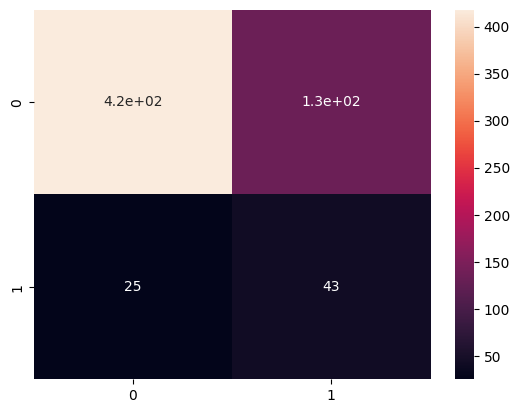

In [137]:
sns.heatmap(confusion_matrix(test_y, preds), annot=True)

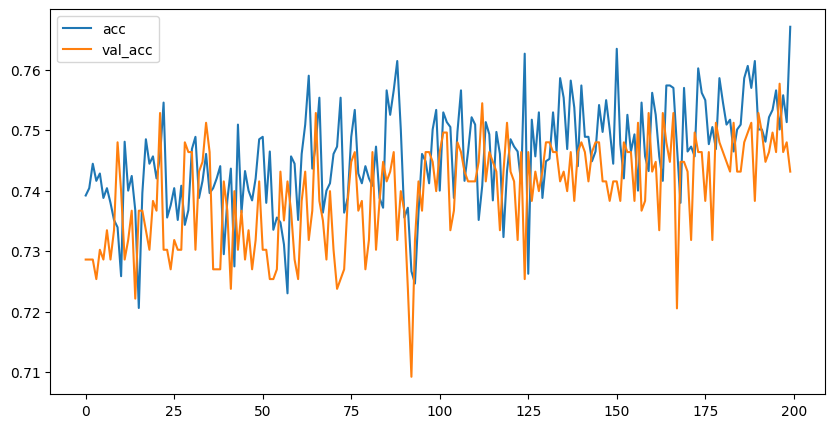

In [130]:
plt.figure(figsize=(10, 5))
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.legend(['acc', 'val_acc'])

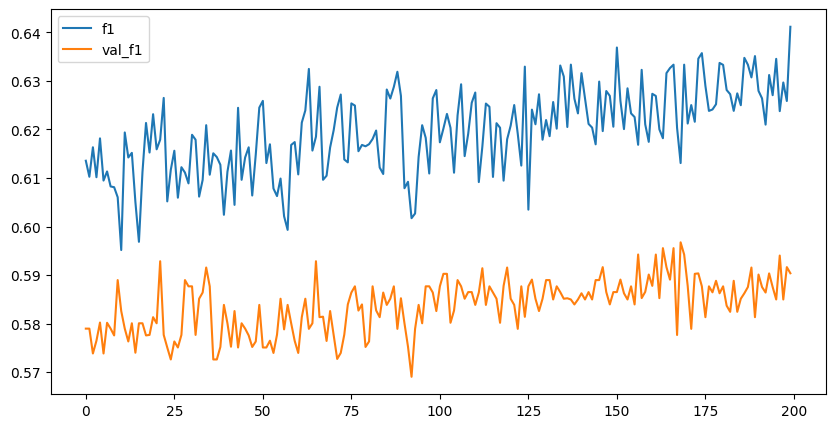

In [131]:
plt.figure(figsize=(10, 5))
plt.plot(hist.history['f1'])
plt.plot(hist.history['val_f1'])
plt.legend(['f1', 'val_f1'])

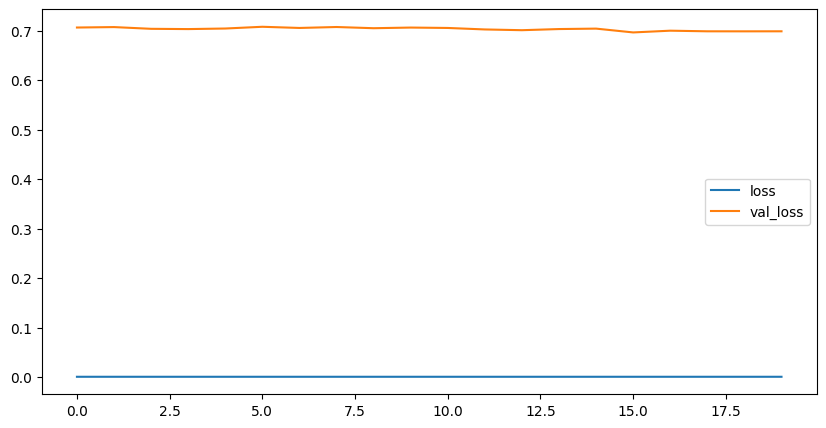

In [204]:
plt.figure(figsize=(10, 5))
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.legend(['loss', 'val_loss'])